In [171]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from scipy import optimize

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 10, 5

## Get initial data

In [159]:
data_df = pd.read_csv('./ml-100k/u.data', sep='\t', header=None, names=['user id','item id','rating','timestamp'])
data_df.head(3)

,user id,item id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116


In [6]:
len(data_df) == len(data_df.dropna(how='any')) #check missing values

True

check if: 
    - users are numbered from 1 to len(np.unique(data_df['user id'])
    - items are numbered from 1 to len(np.unique(data_df['item id'])

In [8]:
(list(np.unique(data_df['user id'])) == range(1,len(np.unique(data_df['user id'])) + 1),\
 list(np.unique(data_df['item id'])) == range(1,len(np.unique(data_df['item id'])) + 1))

(True, True)

### Build matrix of ratings

In [9]:
n_u = len(np.unique(data_df['user id']))
n_m = len(np.unique(data_df['item id']))
Y = np.zeros((n_m, n_u)) # matrix of ratings

In [10]:
u_idx = []               #n_m lists of user indexes
u_ratings = []           #n_m lists of user ratings
for movie in range(n_m):
    u_idx.append(data_df[data_df['item id'] == (movie + 1)].sort_values(by= 'user id')['user id'].values)
    u_ratings.append(data_df[data_df['item id'] == (movie + 1)].sort_values(by= 'user id')['rating'].values)
    for i in range(len(u_idx[movie])):
        Y[movie,:][u_idx[movie][i] - 1] = u_ratings[movie][i]

In [11]:
Bool_mask = np.zeros((Y.shape[0], Y.shape[1])) # boolean mask matrix ( = 1 if rating exists)
Bool_mask[Y != 0] = 1

In [229]:
print ('Sparsity = {:4.2f} %'.format(100*(1 - np.sum(np.sum(Bool_mask, axis = 0))/(n_m*n_u))))

Sparsity = 93.70 %


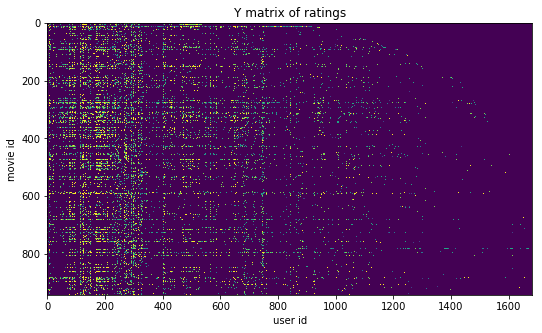

In [173]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xlabel('user id')
ax1.set_ylabel('movie id')

plt.title('Y matrix of ratings')
plt.imshow(Y.T)

## Recommendation engine

### - Learn latent features of existing users and movies using low rank matrix factorization

In [247]:
# number of features
n_f = 10

In [228]:
def cost_function(params, Y, Bool_mask, n_f, lambda_):
    """
    input : params : vector containing user and movies embeddings - params is then reshaped into movies and users
                     matrices (resp. X and Theta) 
            Y : ratings matrix
            Bool_mask : boolean mask for rated movies
            n_f : number of features (number of dimensions for user and movie embeddings)
            lambda_ : regularization parameter
            
    output: J : cost function to minimize
    """
    
    movie_params = params[:Y.shape[0]*n_f]
    user_params = params[-Y.shape[1]*n_f:]
    
    X = np.reshape(movie_params, (Y.shape[0], n_f))
    Theta = np.reshape(user_params, (Y.shape[1], n_f))
    
    J = 0.5*np.sum(np.sum(Bool_mask*(np.dot(X, Theta.T) - Y)**2))
    J = J + (lambda_/2.)*(np.sum(np.sum(X**2)) + np.sum(np.sum(Theta**2)))
    
    return J

In [68]:
def grad_J(params, Y, Bool_mask, n_f, lambda_):
    """
    input : params : vector containing user and movies embeddings - params is then reshaped into movies and users
                     matrices (resp. X and Theta) 
            Y : ratings matrix
            Bool_mask : boolean mask for rated movies
            n_f : number of features (number of dimensions for user and movie embeddings)
            lambda_ : regularization parameter
            
    output: grad_J : vector containing all cost function derivatives, same dimension as params
    """

    movie_params = params[:Y.shape[0]*n_f]
    user_params = params[-Y.shape[1]*n_f:]

    X = np.reshape(movie_params, (Y.shape[0], n_f))
    Theta = np.reshape(user_params, (Y.shape[1], n_f))
    X_grad = np.zeros((Y.shape[0], n_f))
    Theta_grad = np.zeros((Y.shape[1], n_f))
    
    for movie in range(X.shape[0]):
        X_grad[movie,:] = np.dot(Bool_mask[movie,:]*(np.dot(X[movie,:], Theta.T) - Y[movie,:]), Theta)
        X_grad[movie,:] = X_grad[movie,:] + lambda_*X[movie,:]
    
    for user in range(Theta.shape[0]):
        Theta_grad[user,:] = np.dot(X.T, (Bool_mask[:,user]*(np.dot(X, Theta.T[:,user]) - Y[:,user])))
        Theta_grad[user,:] = Theta_grad[user,:] + lambda_*Theta[user,:]
    
    grad_X_params = np.reshape(X_grad, -1)
    grad_Theta_params = np.reshape(Theta_grad, -1)
    grad_params = np.concatenate([grad_X_params, grad_Theta_params])
    
    return grad_params

In [250]:
def normalize_ratings(Y, Bool_mask):
    """
    input : Y : ratings matrix, Bool_mask : boolean mask for rated movies
    output: Y_norm normalized matrix : each movie of Y_norm has a rating of 0 on average
            Y_mean : mean score for each movie in original dataset Y
    """
    Y_norm = np.zeros((Y.shape[0], Y.shape[1]))
    Y_mean = np.zeros(Y.shape[0]) #mean score for each movie

    for movie in range(Y.shape[0]):
        idx = [user for user in range(Y.shape[1]) if (Bool_mask[movie,:][user] == 1)] # index of user ratings, if any
        Y_mean[movie] = np.mean(Y[movie][idx])
        Y_norm[movie][idx] = Y[movie][idx] - Y_mean[movie] # substract mean to every user rating
    
    return Y_norm, Y_mean

In [122]:
def get_prediction_matrix(Y, Bool_mask, n_f, lambda_):
    """
    input : Y : ratings matrix
            Bool_mask : boolean mask for rated movies
            n_f : number of features (number of dimensions for user and movie embeddings)
            lambda_ : regularization parameter
            
    output: prediction_matrix : matrix of predicted ratings
    """
    
    X = np.random.randn(Y.shape[0], n_f)#(scale = 1./n_f, size = (n_m, n_f)) # movie features matrix
    Theta = np.random.randn(Y.shape[1], n_f)#(scale = 1./n_f, size = (n_u, n_f)) # movie features matrix

    x0 = np.concatenate([X.reshape(-1), Theta.reshape(-1)])
    Y_norm, Y_mean = normalize_ratings(Y, Bool_mask)
    
    res1 = optimize.fmin_cg(cost_function, x0, fprime = grad_J, args = (Y_norm, Bool_mask, n_f, lambda_), maxiter = 100)
    
    movie_params = res1[:Y.shape[0]*n_f]
    user_params = res1[-Y.shape[1]*n_f:]

    X = np.reshape(movie_params, (Y.shape[0], n_f))
    Theta = np.reshape(user_params, (Y.shape[1], n_f))

    prediction_matrix = np.dot(X, Theta.T)
    for movie in range(prediction_matrix.shape[0]):
        prediction_matrix[movie,:] += Y_mean[movie]
    
    return prediction_matrix

### - Mapping movie ids to titles

In [165]:
movie_df = pd.read_csv('./ml-100k/u.item', sep='|', header=None, names=['movie id','movie title','release date','video release date','IMDb URL','unknown','Action','Adventure','Animation','Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'])
movie_df.head(3)

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Make recommendations for new user

### - Add new user with some ratings

In [236]:
new_user_ratings = np.zeros((1682, 1));

In [237]:
new_user_ratings[1]= 5;
new_user_ratings[12]= 3;
new_user_ratings[22]= 5;
new_user_ratings[41]= 5;
new_user_ratings[70]= 1;
new_user_ratings[95]= 1;
new_user_ratings[153]= 5;
new_user_ratings[312]= 1;
new_user_ratings[323]= 5;
new_user_ratings[491]= 5;
new_user_ratings[589]= 1;
new_user_ratings[613]= 5;
new_user_ratings[734]= 4;
new_user_ratings[940]= 2;
new_user_ratings[1098]= 5;
new_user_ratings[1265]= 5;
new_user_ratings[1273]= 2;
new_user_ratings[1677]= 5;

In [238]:
for movie in range(len(new_user_ratings)):
    if new_user_ratings[movie] != 0:
        print ('Rated {} for : {}'.format(int(new_user_ratings[movie]), movie_df['movie title'][movie]))

Rated 5 for : GoldenEye (1995)
Rated 3 for : Mighty Aphrodite (1995)
Rated 5 for : Taxi Driver (1976)
Rated 5 for : Clerks (1994)
Rated 1 for : Lion King, The (1994)
Rated 1 for : Terminator 2: Judgment Day (1991)
Rated 5 for : Monty Python's Life of Brian (1979)
Rated 1 for : Titanic (1997)
Rated 5 for : Lost Highway (1997)
Rated 5 for : East of Eden (1955)
Rated 1 for : Hellraiser: Bloodline (1996)
Rated 5 for : Giant (1956)
Rated 4 for : Philadelphia (1993)
Rated 2 for : With Honors (1994)
Rated 5 for : Red Firecracker, Green Firecracker (1994)
Rated 5 for : Bread and Chocolate (Pane e cioccolata) (1973)
Rated 2 for : Robocop 3 (1993)
Rated 5 for : Mat' i syn (1997)


### - Define updated ratings matrix with new user info

In [239]:
Y_new = np.hstack((Y, new_user_ratings))
Bool_mask_new = np.hstack((Bool_mask, np.ones((Y.shape[0], 1))*(new_user_ratings != 0)))

In [240]:
Y_norm, Y_mean =normalize_ratings(Y_new, Bool_mask_new)

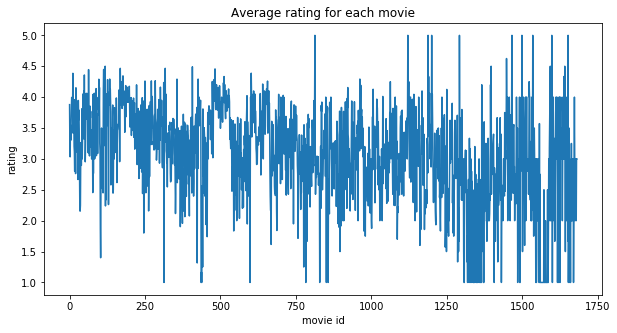

In [241]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xlabel('movie id')
ax1.set_ylabel('rating')

plt.title('Average rating for each movie')
plt.plot(Y_mean)

### - Calculate matrix of predicted ratings

In [249]:
prediction_matrix = get_prediction_matrix(Y_new, Bool_mask_new, n_f, lambda_ = 10)

         Current function value: 38971.073648
         Iterations: 100
         Function evaluations: 153
         Gradient evaluations: 153


In [251]:
new_user_predicted_ratings = prediction_matrix[:,-1]

In [261]:
recomm_df = pd.concat([movie_df.loc[:,['movie id','movie title']], \
                      pd.Series(new_user_predicted_ratings, name='predicted ratings')],\
                      axis=1)
recomm_df = pd.concat([recomm_df, pd.Series(Bool_mask_new[:,-1], name = 'rated')], axis = 1)
recomm_df = recomm_df[recomm_df['rated'] == 0] # mask movies already rated
recomm_df = recomm_df.drop('rated', axis = 1)

In [262]:
recomm_df = recomm_df.sort_values(by='predicted ratings', ascending=False)

### Top 50 most recommended movies

In [264]:
recomm_df.head(50)

,movie id,movie title,predicted ratings
1535,1536,Aiqing wansui (1994),5.000002
813,814,"Great Day in Harlem, A (1994)",5.000001
1200,1201,Marlene Dietrich: Shadow and Light (1996),5.000000
1121,1122,They Made Me a Criminal (1939),5.000000
1652,1653,Entertaining Angels: The Dorothy Day Story (1996),5.000000
1466,1467,"Saint of Fort Washington, The (1993)",5.000000
1598,1599,Someone Else's America (1995),5.000000
1292,1293,Star Kid (1997),4.999999
1188,1189,Prefontaine (1997),4.999999
1499,1500,Santa with Muscles (1996),4.999999
